In [1]:
%pylab inline

import re
import pandas as pd
from functools import partial
from mpl_toolkits.basemap import Basemap

Populating the interactive namespace from numpy and matplotlib


# Star cartography with Scipy and Pandas

The other day I decided I wanted to learn a little bit about astronomy. My goal was to get a better understanding of how we describe celestial objects, develop some general tools for working with celestial data, and draw some pretty pictures. 

![img](./starmap.jpg)

To get this going I compiled together a dataset from wikipedia, cleaned it up, and put it into a .csv file that you can use at your own risk. I used pandas to manipulate the dataset and the matplotlib library Basemap for plotting cartographic data.

So I'm gonna take you through that process and explain some of the concepts along the way. First though we have to load that dataset.

In [2]:
starsdf = pd.read_csv('./constellations.csv')

starsdf.head()

,Name,Right Ascension,Declination,Apparent Magnitude,Constellation
0,Alpha Andromedae,00h 08m 23.17s,+29° 05′ 27.0″,2.07,Andromeda
1,Beta Andromedae,01h 09m 43.80s,+35° 37′ 15.0″,2.07,Andromeda
2,Gamma Andromedae,02h 03m 53.92s,+42° 19′ 47.5″,2.10,Andromeda
3,Delta Andromedae,00h 39m 19.60s,+30° 51′ 40.4″,3.27,Andromeda
4,Andromeda Galaxy,00h 42m 44.31s,+41° 16′ 09.4″,3.44,Andromeda


Okay, let me also explain some of the columns and terms we'll be using:

- [Constellation](https://en.wikipedia.org/wiki/88_modern_constellations): These are just regional groupings of the stars in the sky; there are 88 modern constellations.
- [Right Ascension](https://en.wikipedia.org/wiki/Right_ascension): This relates to the geographic Longitude, how far to the East of the prime meridian something is, except instead of degrees it's measured in hours, minutes, and seconds.
- [Declination](https://en.wikipedia.org/wiki/Declination): This relates to geographic Latitude, how far north or south; this time measured in degrees, arcminutes, and arcseconds.
- [Epoch](https://en.wikipedia.org/wiki/Epoch_%28astronomy%29): An epoch is a point in time used as a reference for celestial coordinates. Usually given as midnight January 1st 2000.
- [Apparent Magnitude](https://en.wikipedia.org/wiki/Apparent_magnitude): A funny way of measuring how bright a star looks. I say funny because it's an inverse logarithmic scale, meaning 6.5 is the limit of stars visible to the naked eye and the sun has an apparent magnitude of -27.
- [Asterism](https://en.wikipedia.org/wiki/Asterism_%28astronomy%29): A pattern of stars, think big dipper.

Now the first thing I did was write some helper functions to convert from celestial to geographic coordinates.

In [3]:
from functools import wraps

def nan(f):
    '''Function decorator that returns a nan on Exception'''
    
    @wraps(f)
    def wrapped(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except Exception:
            return np.nan
    
    return wrapped

@nan
def ra2long(ra):
    '''Parse string representing right ascension into a longitudinal angle'''
    
    h, m, s = (float(x) for x in re.match(r'(.*)h\s*(.*)m\s*(.*)s', ra.lower()).groups())

    return 360 * (h / 24 + m / 24 / 60 + s / 24 / 60 / 60)

@nan
def dec2lat(dec):
    '''Parse declination into a latitudinal angle'''
    
    d, m, s = (float(x) for x in re.match(r'(.*)°\s*(.*)′\s*(.*)″', dec.lower()).groups())
    
    return d + np.copysign(m / 60, d)  + np.copysign(s / 3600, d)

# Add these new columns to our DataFrame
starsdf['Latitude'] = starsdf['Declination'].apply(dec2lat)
starsdf['Longitude'] = starsdf['Right Ascension'].apply(ra2long)

starsdf.head()

,Name,Right Ascension,Declination,Apparent Magnitude,Constellation,Latitude,Longitude
0,Alpha Andromedae,00h 08m 23.17s,+29° 05′ 27.0″,2.07,Andromeda,29.090833,2.096542
1,Beta Andromedae,01h 09m 43.80s,+35° 37′ 15.0″,2.07,Andromeda,35.620833,17.432500
2,Gamma Andromedae,02h 03m 53.92s,+42° 19′ 47.5″,2.10,Andromeda,42.329861,30.974667
3,Delta Andromedae,00h 39m 19.60s,+30° 51′ 40.4″,3.27,Andromeda,30.861222,9.831667
4,Andromeda Galaxy,00h 42m 44.31s,+41° 16′ 09.4″,3.44,Andromeda,41.269278,10.684625


Then I filtered out all stars that would not be visible to the naked eye.

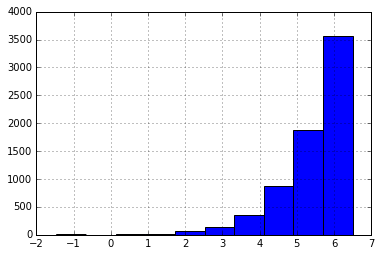

In [4]:
min_am = 6.5

# DataFrame of visible stars
visdf = starsdf[starsdf['Apparent Magnitude'] <= min_am]

long = visdf.Longitude
lat = visdf.Latitude
ams = ((visdf['Apparent Magnitude'].max() - visdf['Apparent Magnitude'])) / (visdf['Apparent Magnitude'].max() - visdf['Apparent Magnitude'].min())

visdf['Apparent Magnitude'].hist()
plt.show()

Then I created a dataset of just the constellations. This is useful when you want to label them later.

In [5]:
# Pull out into data accquisition notebook

constellations = {
    'Name': [],
    'Latitude': [],
    'Longitude': []
}

for c in starsdf['Constellation'].unique():
    constellations['Name'].append(c)
    constellations['Latitude'].append(visdf[visdf['Constellation'] == c].Latitude.median())
    constellations['Longitude'].append(visdf[visdf['Constellation'] == c].Longitude.median())
    
constellationsdf = pd.DataFrame(constellations)

print(constellationsdf.Name.unique())

['Andromeda' 'Antlia' 'Apus' 'Aquarius' 'Aquila' 'Ara' 'Aries' 'Auriga'
 'Boötes' 'Caelum' 'Camelopardalis' 'Cancer' 'Canes Venatici' 'Canis Major'
 'Canis Minor' 'Capricornus' 'Carina' 'Cassiopeia' 'Centaurus' 'Cepheus'
 'Cetus' 'Chamaeleon' 'Circinus' 'Columba' 'Coma Berenices'
 'Corona Australis' 'Corona Borealis' 'Corvus' 'Crater' 'Crux' 'Cygnus'
 'Delphinus' 'Dorado' 'Draco' 'Equuleus' 'Eridanus' 'Fornax' 'Gemini'
 'Grus' 'Hercules' 'Horologium' 'Hydra' 'Hydrus' 'Indus' 'Lacerta' 'Leo'
 'Leo Minor' 'Lepus' 'Libra' 'Lupus' 'Lynx' 'Lyra' 'Mensa' 'Microscopium'
 'Monoceros' 'Musca' 'Norma' 'Octans' 'Ophiuchus' 'Orion' 'Pavo' 'Pegasus'
 'Perseus' 'Phoenix' 'Pictor' 'Pisces' 'Piscis Austrinus' 'Puppis' 'Pyxis'
 'Reticulum' 'Sagitta' 'Sagittarius' 'Scorpius' 'Sculptor' 'Scutum'
 'Serpens' 'Sextans' 'Taurus' 'Telescopium' 'Triangulum'
 'Triangulum Australe' 'Tucana' 'Ursa Major' 'Ursa Minor' 'Vela' 'Virgo'
 'Volans' 'Vulpecula']


Some more helper to convert back to celestial coordinates. These are used in the Basemap `drawmeridian` and `drawparallels` functions for custom labels.

In [6]:
def long2ra(long, fmtstr='{:.0f}h {:.0f}m {:.2f}s'):
    '''Convert a longitude to a Right Ascension according to fmt'''
    
    m, h = np.modf(long / 360 * 24)
    s, m = np.modf(m * 60)
    s *= 60
    
    return fmtstr.format(h, m, s)

def lat2dec(lat, fmtstr='{:.0f}° {:.0f}\' {:.2f}\"'):
    '''Convert a Latitude to a Declination according to fmt'''
    
    m, d = np.modf(lat)
    s, m = np.modf(m * 60)
    s *= 60
    
    return fmtstr.format(d, m, s)

# Useful for labelling parrallels and meridians
slong2ra = partial(long2ra, fmtstr='{:.0f}h')
slat2dec = partial(lat2dec, fmtstr='{:.0f}°')

print((long2ra(95), slong2ra(95)))
print((lat2dec(50), slong2ra(50)))

('6h 20m 0.00s', '6h')
('50° 0\' 0.00"', '3h')


And now we're ready to plot. A canonical example in astronomy is to plot the northern and southern hemispheres with the constellations labeled.

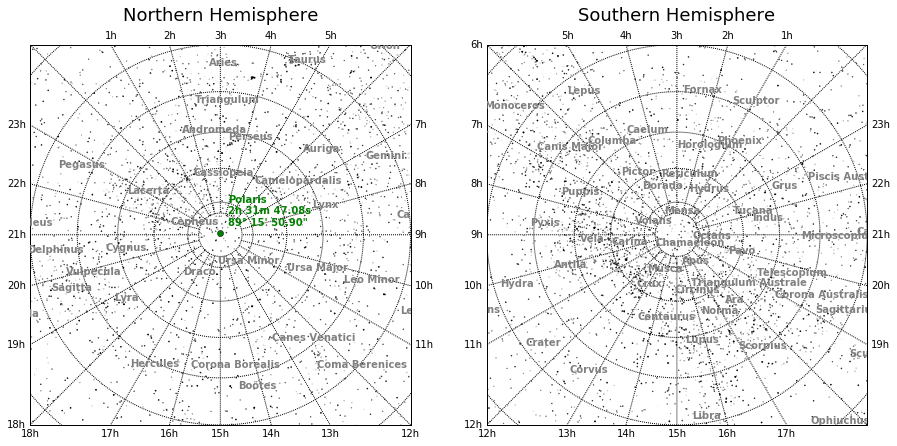

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches((15, 15))

map1 = Basemap(projection='npstere', boundinglat=15, lon_0=135, ax=ax1, celestial=True)
map2 = Basemap(projection='spstere', boundinglat=-15, lon_0=135, ax=ax2, celestial=True)

map1.drawmeridians(np.arange(0,360,15), labels=[1, 1, 1, 1],fmt=slong2ra)
map2.drawmeridians(np.arange(0,360,15), labels=[1, 1, 1, 1], fmt=slong2ra)

map1.drawparallels(np.arange(-90,90,15))
map2.drawparallels(np.arange(-90,90,15))

# Plot Stars
map1.scatter(long.values, lat.values, s=ams.values, c='k', latlon=True)
map2.scatter(long.values, lat.values, s=ams.values, c='k', latlon=True)

ax1.set_title('Northern Hemisphere', y=1.05, size=18)
ax2.set_title('Southern Hemisphere', y=1.05, size=18)

# Label Constellations
for _, i in constellationsdf.iterrows():
    xpt, ypt = map1(i.Longitude, i.Latitude)
    ax1.text(xpt, ypt, i.Name, transform=ax1.transData, clip_on=True, color='grey', weight='semibold')
    
    xpt, ypt = map2(i.Longitude, i.Latitude)
    ax2.text(xpt, ypt, i.Name, transform=ax2.transData, clip_on=True, color='grey', weight='semibold')
    
# North Star
polaris_long = starsdf[starsdf.Name == 'Polaris'].Longitude.values[0]
polaris_lat = starsdf[starsdf.Name == 'Polaris'].Latitude.values[0]

p_xpt, p_ypt = map1(polaris_long, polaris_lat)

ax1.plot(p_xpt, p_ypt, 'go')
ax1.text(p_xpt + 4e5, p_ypt + 4e5, 'Polaris\n{}\n{}'.format(long2ra(polaris_long), lat2dec(polaris_lat)),
         size=10, fontdict={'weight':'semibold','color':'g'})

plt.show()

You might also want to plot a close-up of a specific constellation. So let's look at Ursa Minor, highlight the region of space it occupies, and present it's main asterism.

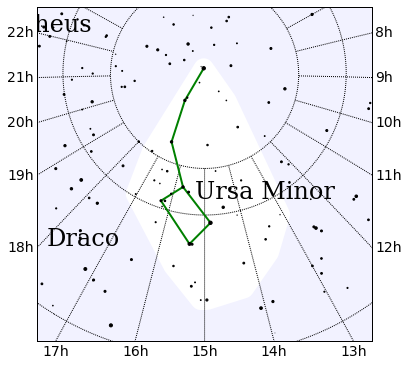

In [15]:
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Ursa Minor Asterism created by the stars:
# alpha umi, delta umi, epsilon umi, zeta umi, beta umi, gamma umi, eta umi, zeta umi
um = starsdf[starsdf.Constellation == 'Ursa Minor'].iloc[[0, 6, 3, 5, 1, 2, 9, 5]]

# Plot Sky
plt.gcf().set_size_inches((6, 6))

map1 = Basemap(projection='stere', celestial=True, width=4e6, height=4e6, lat_ts=50,
              lat_0=um.Latitude.mean(), lon_0=135)

map1.drawmeridians(np.arange(0,360,15), labels=[1, 1, 0, 1], fmt=slong2ra, size=14)
map1.drawparallels(np.arange(-90,90,15))

um_xpt, um_ypt = map1(um.Longitude.mean(), um.Latitude.mean())

# Compute convex hull of visible stars in the Ursa Minor Constellation
points = np.array(map1(starsdf[starsdf.Constellation == 'Ursa Minor'].Longitude.values,
                       starsdf[starsdf.Constellation == 'Ursa Minor'].Latitude.values)).T
hull = ConvexHull(points)
points = hull.points[hull.vertices]
path = Path(points, closed=True)
patch = PathPatch(path, facecolor='white', edgecolor='w', lw=20, joinstyle='round')

# Set bg color and highlight constellation
plt.gca().set_axis_bgcolor((.95, .95, 1.))
plt.gca().add_patch(patch)

# Plot Ursa Minor Asterism
map1.plot(um.Longitude.values, um.Latitude.values, 'g-', linewidth=2, latlon=True, zorder=3)

# Plot Stars
map1.scatter(long.values, lat.values, s=20*ams.values, c='k', latlon=True, zorder=4)

# Label Constellations
for _, i in constellationsdf.iterrows():
    xpt, ypt = map1(i.Longitude, i.Latitude)
    plt.gca().text(xpt, ypt, i.Name, clip_on=True, size=24, family='serif')

plt.show()